1. Objective

My goal is to train and validate a regression model to predict the age of an abalone based off a number of details. Our dataset contains info icluding the gender, weight, and size of avalones along with the number of rings they have, which we use as a proxy for age.

In [1]:
# Import libraries

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler


# For reproducibility
RNG = 42
np.random.seed(RNG)

ModuleNotFoundError: No module named 'seaborn'

2. Pipeline

2.1 Import Dataset

2.2 Encode Gender into 3 seperate columns

2.3 Check for missing or duplicate samples

2.4 Seperate "Age" column from dataset

2.5 Split dataset into 2 testing and training datasets

2.6 Scale data using robust scaler

2.7 Set up regression model

2.8 Train model

In [ ]:
# dataset path
DATA_PATH = r"abalone.data.csv" 

# Load dataset as pandas DataFrame
df = pd.read_csv(DATA_PATH, sep=",")
assert "Rings" in df.columns, "Expected 'Rings' column." # Assert Rings column exists
print(df.shape)
# df.head()


(4177, 9)


In [ ]:
# Converting gender to 3 separate one-hot encoded columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['gender'])  # Apply OneHotEncoder to column 3
    ],
    remainder='passthrough'  # Keep the other columns
)

datEnc = preprocessor.fit_transform(df)

# Get the new column names created by the transformer
new_columns = preprocessor.get_feature_names_out()

# Create a new DataFrame with the transformed data and new column names
dfEnc = pd.DataFrame(datEnc, columns=new_columns)

dfEnc = dfEnc.rename(columns={"cat__gender_F": "gender_F", "cat__gender_I": "gender_I", "cat__gender_M": "gender_M", "remainder__Length": "length", "remainder__Diameter": "diameter", "remainder__Height" : "height", "remainder__Whole weight" : "whole_weight", "remainder__Shucked weight": "shucked_weight", "remainder__Viscera weight" : "viscera_weight", "remainder__Shell weight" : "shell_weight", "remainder__Rings" : "Rings"})
print(dfEnc.shape)
dfEnc.head()

(4177, 11)


,gender_F,gender_I,gender_M,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,Rings
0,0.0,0.0,1.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15.0
1,0.0,0.0,1.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7.0
2,1.0,0.0,0.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9.0
3,0.0,0.0,1.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10.0
4,0.0,1.0,0.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7.0


In [ ]:
# Summary statistics and check for missing values
display(dfEnc.describe(include='all'))
print("\nMissing values per column:")
print(dfEnc.isna().sum().sort_values(ascending=False))
# Check for duplicates
num_duplicates = dfEnc.duplicated().sum()
print(f"Number of duplicates: {num_duplicates}")

,gender_F,gender_I,gender_M,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.312904,0.321283,0.365813,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.463731,0.467025,0.481715,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.000000,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.000000,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.000000,0.000000,0.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,1.000000,1.000000,1.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,1.000000,1.000000,1.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000



Missing values per column:
gender_F          0
gender_I          0
gender_M          0
length            0
diameter          0
height            0
whole_weight      0
shucked_weight    0
viscera_weight    0
shell_weight      0
Rings             0
dtype: int64
Number of duplicates: 0


In [ ]:
# Split data into features and target variable
X = dfEnc.drop(columns=["Rings"])
y_reg = dfEnc["Rings"]

# Split data into training and testing sets for regression
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=RNG
)

In [ ]:
# Scale data to normalized range and set ridge model
reg_pipe = Pipeline([
    ("scaler", RobustScaler()), # StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=RNG))
])

In [ ]:

# Cross-validation for regression
kf = KFold(n_splits=5, shuffle=True, random_state=RNG)
cv_reg = cross_validate(
    reg_pipe, X_train_r, y_train_r, cv=kf, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True
)

print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")


NameError: name 'KFold' is not defined

In [ ]:
# Fit model on training data
t0 = time.time()
reg_pipe.fit(X_train_r, y_train_r)
train_time = time.time() - t0

3. Results


In [ ]:
# Predict on test data
t1 = time.time()
y_pred_r = reg_pipe.predict(X_test_r)
pred_time = time.time() - t1

In [ ]:
# Evaluate regression model on test data
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
mae = mean_absolute_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)
print(f"Test RMSE: {rmse:.3f} | Test MAE: {mae:.3f} | Test R2: {r2:.3f}")
print(f"Train time: {train_time*1000:.1f} ms | Predict time: {pred_time*1000:.1f} ms")

Test RMSE: 2.212 | Test MAE: 1.595 | Test R2: 0.548
Train time: 21.5 ms | Predict time: 4.9 ms


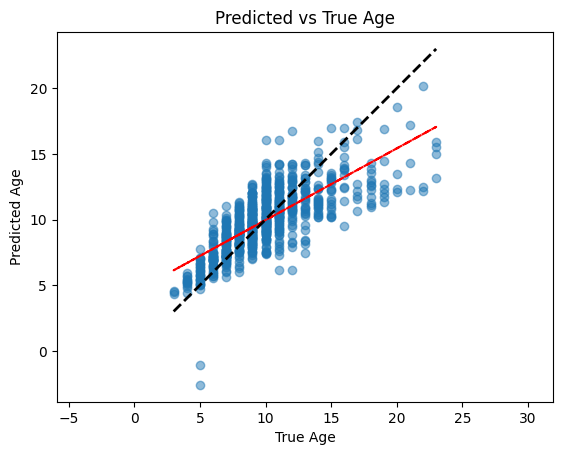

In [ ]:
# plot predicted vs real outcomes
plt.plot(y_test_r.values, y_pred_r, 'o', alpha=0.5)
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("Predicted vs True Age")
# plot best fit line
z = np.polyfit(y_test_r, y_pred_r, 1)
p = np.poly1d(z)
plt.plot(y_test_r, p(y_test_r), "r--")
# Add a diagonal line for reference
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'k--', lw=2)
# match axes scales
plt.axis('equal')
plt.show()

In [ ]:
# Learning curve (Regression, R2)
train_sizes, train_scores, val_scores = learning_curve(
    reg_pipe, X_train_r, y_train_r, cv=kf, scoring="r2", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6), shuffle=True, random_state=RNG
)
plt.figure()
plt.title("Learning Curve — Regression (Ridge, R2)")
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Training R2")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="Validation R2")
plt.xlabel("Training samples"); plt.ylabel("R2"); plt.legend(); plt.grid(True)
plt.show()

NameError: name 'learning_curve' is not defined